# HPC Anomaly Detection: GNN training

## Preliminary steps

In [1]:
! pip install dgl torch_geometric torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 53.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=1256b33ad5779d6eb35a995c441624fe9c24d256eec8a9b1e205a5c30dced3de
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=2f5ba16a7b492ce7d8ed7cab9e0fdc821d7b6e1e0ae960bafc3fe9caeeb93fbb
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torch_geometric torchviz


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! if ! [ -d data ]; then cp -r drive/MyDrive/HPCDATA/data .; fi
! if ! [ -d utils ]; then cp -r drive/MyDrive/HPCDATA/utils .; fi

In [4]:
import itertools
import json
import logging
import os
import shutil
import random
from timeit import default_timer

import dgl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (auc, roc_curve, confusion_matrix,
                            ConfusionMatrixDisplay,precision_recall_curve,
                            classification_report)
from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torchviz import make_dot

from utils.data_processing import *
from utils.training_simple import *
from utils.plotting import *

from tqdm.notebook import tqdm

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## Reproducibility

In [5]:
RANDOM_SEED = None # Set a random seed to allow for reproducibility (it will slow down computations)

def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  os.environ['CUBLAS_WORKSPACE_CONFIG']=':16:8'

def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

g = None
if RANDOM_SEED is not None:
  g = torch.Generator()
  g.manual_seed(RANDOM_SEED)
  set_reproducibility(RANDOM_SEED)

## Read and process Node Metrics

In [59]:
AGGREGATED_METRICS_PATH = "data/aggregated/"
JOB_TABLE_PATH = 'data/job_table.parquet'
RACKS_DATA_PATH = 'data/racks_spatial_distribution.json'
WINDOW_SIZE = 10
DROP_TH = 100
KEEPRACKS = np.arange(23,28)
KEEPNODES = np.arange(460,559).astype(str) # set it no None if you don't want to filter nodes

In [60]:
data = load_metrics(AGGREGATED_METRICS_PATH,racks=KEEPRACKS)
data = process_metrics(data,KEEPNODES,DROP_TH)
data.head()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

timestamp  \
0 2022-03-31 02:45:00+00:00   
1 2022-03-31 03:00:00+00:00   
2 2022-03-31 03:15:00+00:00   
3 2022-03-31 03:30:00+00:00   
4 2022-03-31 03:45:00+00:00   

                                                 460  \
0  [0.539976015665201, 0.5405405022263785, 0.5315...   
1  [0.5129274204992378, 0.5045045002473754, 0.522...   
2  [0.5151152414633041, 0.5045045002473754, 0.522...   
3  [0.5079552656588584, 0.5045045002473754, 0.513...   
4  [0.49940312291625616, 0.4954954567943217, 0.50...   

                                                 461  \
0  [0.3955845662662844, 0.40540536593020815, 0.37...   
1  [0.3570007782344892, 0.3513513629617035, 0.360...   
2  [0.360381867804047, 0.3513513629617035, 0.3603...   
3  [0.3534208510275159, 0.3513513629617035, 0.360...   
4  [0.3424821103786812, 0.3423423195086498, 0.342...   

                                                 463  \
0  [0.4160699413210467, 0.43243241037276337, 0.38...   
1  [0.3747015766319405, 0.36936936395120507, 0.37...   
2  [0.37708811384292334, 0.3783784074042587, 0.37...   
3  [0.3729116130284538, 0.3783784074042587, 0.378...   
4  [0.36137611668637437, 0.36936936395120507, 0.3...   

                                                 464  \
0  [0.46081933488446114, 0.47747745580482015, 0.4...   
1  [0.41865537686469456, 0.4144144093832618, 0.42...   
2  [0.4196496864422715, 0.4234234528363155, 0.423...   
3  [0.4188542751973597, 0.4234234528363155, 0.414...   
4  [0.4061256316402878, 0.4144144093832618, 0.405...   

                                                 465  \
0  [0.4759347584335139, 0.48648649925787385, 0.45...   
1  [0.4331741661110016, 0.4234234528363155, 0.432...   
2  [0.4321796744476762, 0.43243241037276337, 0.43...   
3  [0.4349641904097378, 0.45045041136226494, 0.43...   
4  [0.4222354861574164, 0.43243241037276337, 0.42...   

                                                 467  \
0  [0.5871120678300974, 0.6036036345645427, 0.576...   
1  [0.5624501919608657, 0.5585585891324859, 0.558...   
2  [0.5626489689030316, 0.5675675466689337, 0.558...   
3  [0.5670245501359148, 0.5675675466689337, 0.558...   
4  [0.5546935818536741, 0.5675675466689337, 0.549...   

                                                 468  \
0  [0.5280428440482905, 0.5495495456794321, 0.504...   
1  [0.49602203334669837, 0.4954954567943217, 0.49...   
2  [0.492442227530224, 0.4954954567943217, 0.4774...   
3  [0.4996021426394202, 0.5135135437004291, 0.495...   
4  [0.48468561742303257, 0.4954954567943217, 0.47...   

                                                 469  \
0  [0.5684167170740713, 0.5945945911114889, 0.540...   
1  [0.5397770566372865, 0.5495495456794321, 0.531...   
2  [0.5385837880317951, 0.5495495456794321, 0.522...   
3  [0.5459426014736564, 0.5585585891324859, 0.540...   
4  [0.5310261369525181, 0.5495495456794321, 0.522...   

                                                 470  ...  \
0  [0.612370456611576, 0.6216216355540441, 0.6036...  ...   
1  [0.590095239343826, 0.5855855476584353, 0.5945...  ...   
2  [0.5922830603078925, 0.6036036345645427, 0.594...  ...   
3  [0.5956641498774502, 0.5945945911114889, 0.594...  ...   
4  [0.5839298158979552, 0.6036036345645427, 0.576...  ...   

                                                 551  \
0  [0.6630866180691942, 0.6756756385225489, 0.657...   
1  [0.6591088941968907, 0.6666666809861009, 0.639...   
2  [0.649562259790963, 0.6576576375330473, 0.6306...   
3  [0.6549322719919222, 0.6666666809861009, 0.648...   
4  [0.6551311096293376, 0.6576576375330473, 0.648...   

                                                 552  \
0  [0.7486076813237196, 0.7477477283971609, 0.747...   
1  [0.7482098846583893, 0.7477477283971609, 0.738...   
2  [0.7400557206668658, 0.7387387708607129, 0.738...   
3  [0.7452264703636629, 0.7477477283971609, 0.747...   
4  [0.7464198603596534, 0.7477477283971609, 0.747...   

                                                 553  \
0  [0.7484088436863042, 0.747747728397

## Read Jobs and Racks Tables

In [61]:
node_columns = data.columns[1:-3]
nodes = list(node_columns.astype(int))

racks = pd.read_json(RACKS_DATA_PATH)

jobtable = pd.read_parquet(JOB_TABLE_PATH)[['start_time','end_time','nodes']]
jobtable = jobtable.dropna(subset=['nodes'])
jobtable.nodes = jobtable.nodes.map(lambda x:np.fromstring(x.strip(']['),dtype=int,sep=',')) # map nodelist from str to array
jobtable.nodes = jobtable.nodes.map(lambda a : np.intersect1d(a,nodes)) # Keep only jobs where the selected nodes appear
jobtable = jobtable[jobtable.nodes.map(len)>0] # Drop rows without any node of interest
jobtable = jobtable.reset_index() # Not really necessary, but meh
print("Data covering the period from {} to {}".format(jobtable.start_time.min().date(),jobtable.end_time.max().date()))
jobtable.head()

Data covering the period from 2022-03-31 to 2022-04-30


index                start_time                  end_time  \
0     19 2022-04-02 05:36:25+00:00 2022-04-02 13:23:12+00:00   
1    780 2022-04-01 23:28:45+00:00 2022-04-01 23:29:22+00:00   
2   2096 2022-04-02 16:09:02+00:00 2022-04-02 16:11:31+00:00   
3   2953 2022-04-08 22:16:15+00:00 2022-04-09 05:46:26+00:00   
4   3015 2022-04-09 06:01:58+00:00 2022-04-09 06:02:12+00:00   

                                           nodes  
0       [529, 530, 531, 532, 533, 534, 535, 536]  
1            [467, 493, 494, 495, 512, 513, 514]  
2                      [474, 491, 512, 536, 552]  
3  [463, 464, 488, 489, 507, 512, 513, 522, 542]  
4                                          [464]

## Create graphs

In [62]:
def build_graph(jobs):
  edge_list = jobs.nodes.map(lambda x: list(itertools.permutations(x,2))) # build edgelist for each node
  edge_list = edge_list[edge_list.map(len) > 0]
  if len(edge_list) > 0:
    true_edges = np.concatenate(edge_list.values) # remove empty list and collect all
    heatmap = build_heatmap(true_edges)

  else:
    heatmap = np.zeros((980,980))
    true_edges = np.empty(0)

  src,dst = np.nonzero(heatmap)
  graph = dgl.graph((src,dst),num_nodes=980)

  eweights = torch.tensor(heatmap[heatmap.nonzero()],dtype=torch.float32)

  graph = dgl.graph((src,dst),num_nodes=980)
  graph.edata['eweight'] = eweights

  # Drop nodes not contained in the dataset
  drop_nids = [i for i in range(980) if str(i) not in data.columns]
  graph = dgl.remove_nodes(graph, drop_nids, store_ids=True)

  # Add self loops
  graph = dgl.add_self_loop(graph)
  return graph

In [64]:
data_list = []

for i,row in tqdm(data.iterrows(), total=len(data)):
    timestamp = row['timestamp']
    jobs = jobtable[(jobtable['start_time']<timestamp) & (jobtable['end_time']>timestamp)]
    if len(jobs) > 0:
      graph = build_graph(jobs)
      # Graph changes, so are the weights
      eweights = graph.edata['eweight']
      edge_index = torch.stack(graph.edges())
      x = torch.tensor(np.stack(row.iloc[1:-2]),dtype = torch.float32)
      a = torch.tensor(row['anomalies'])
      g = Data(edge_index=edge_index,x=x,edge_weight = eweights,anomalies=a)
      data_list.append(g)

  0%|          | 0/2963 [00:00<?, ?it/s]

## Model Definition & Training Setup

In [65]:
class anomaly_anticipation(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #encoder
        self.conv1 = GCNConv(in_channels, 300)
        self.conv2 = GCNConv(300, 100)
        self.conv3 = GCNConv(100, out_channels)

        #dense layer
        self.fc1 = torch.nn.Linear(out_channels,16)
        self.fc2 = torch.nn.Linear(16,1)

    def forward(self, x, edge_index,edge_weight=None):
        x = self.conv1(x, edge_index,edge_weight).relu()
        x = self.conv2(x, edge_index,edge_weight).relu()
        x = self.conv3(x, edge_index,edge_weight).relu()
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [66]:
# Create model
in_channels, out_channels = data_list[0].x.shape[1], 16
model = anomaly_anticipation(in_channels,out_channels)

tot_params = 0
for name,param in model.named_parameters():
    print(name,param.shape,param.numel())
    tot_params += param.numel()
print('Total trainable Params:',tot_params)

# Make a forward pass
g = data_list[0]
x = g.x
out = model (x,g.edge_index,g.edge_weight)

# Backtrack to draw the computational graph
make_dot(out, params=dict(list(model.named_parameters())))

conv1.bias torch.Size([300]) 300
conv1.lin.weight torch.Size([300, 416]) 124800
conv2.bias torch.Size([100]) 100
conv2.lin.weight torch.Size([100, 300]) 30000
conv3.bias torch.Size([16]) 16
conv3.lin.weight torch.Size([16, 100]) 1600
fc1.weight torch.Size([16, 16]) 256
fc1.bias torch.Size([16]) 16
fc2.weight torch.Size([1, 16]) 16
fc2.bias torch.Size([1]) 1
Total trainable Params: 157105


In [67]:
def train(train_data, logpath, logger_name, device, num_epochs, initial_lr, batch_size,es_patience, es_min_delta = 0, max_num_ckpt=-1, apply_weight_balancing = False):

  # Create model
  in_channels, out_channels = train_data[0].x.shape[1], 16
  model = anomaly_anticipation(in_channels,out_channels).to(device)

  # Prepare dataloader
  train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False)

  # Compute weight balancing
  pos_weight = None
  if APPLY_WEIGHT_BALANCING:
    train_labels = torch.cat([g.y for g in train_data])
    train_ones = len(train_labels.nonzero())
    train_zeros = len(train_labels)-train_ones
    pos_weight = torch.tensor(train_zeros/train_ones) * 100
    # pos_weight = torch.tensor(train_ones/train_zeros)

  # Set up training
  criterion = torch.nn.BCEWithLogitsLoss(weight = pos_weight)
  optimizer = torch.optim.Adam([p for p in model.parameters()],lr = initial_lr)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epochs,eta_min=initial_lr * 1e-1)
  trainer =  MyTrainer(model,
                       optimizer,
                       scheduler,
                       es_patience,
                       es_min_delta,
                       max_num_ckpt)

  trainer.train(num_epochs,criterion,train_loader,logger_name,device,logpath)
  model.load_state_dict(torch.load(os.path.join(logpath,'BestModel/best-model.pt'))['model'])
  return model

def get_predictions(model,dataloader,device):
    model.eval()

    preds = []
    y_true = []
    anomalies = []

    with torch.no_grad():
        for g in tqdm(dataloader):
            g = g.to(device)

            # Forward pass
            logits = model(g.x,g.edge_index,g.edge_weight).squeeze()

            pred = torch.sigmoid(logits)
            preds.append(pred.detach().cpu().numpy())
            y_true.append(g.y.detach().cpu().numpy())
            anomalies.append(g.anomalies.cpu().numpy())
    preds = np.concatenate(preds).astype(float)
    y_true = np.concatenate(y_true).astype(int)
    anomalies = np.concatenate(anomalies).astype(int)

    return pd.DataFrame({'prob': preds,'true_class': y_true,'anomaly':anomalies})

## Training Setup

In [68]:
TRAIN_SPLIT = 0.7
NUM_EPOCHS = 200
INITIAL_LR = 1e-3

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

ES_PATIENCE = 50
ES_MIN_DELTA = 0

APPLY_WEIGHT_BALANCING = True # whether to use weight balancing inside the loss

LOGGER_NAME = f'train.output'
BASE_LOGPATH = f'out'

MAX_NUM_CKPT = 10

In [69]:
# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Available device:',device)

if not os.path.exists(BASE_LOGPATH):
  os.makedirs(BASE_LOGPATH)

Available device: cuda


# Window size 4

In [70]:
model = anomaly_anticipation(23,1).to(device)

In [71]:
window_size = 4
labels = compute_labels(data,window_size)
for i,g in enumerate(data_list):
  g.y = labels[i]

  0%|          | 0/2963 [00:00<?, ?it/s]

In [72]:
train_data, test_data = train_test_split(data_list,TRAIN_SPLIT)
logpath = f'{BASE_LOGPATH}/{window_size:02d}'
logger_name = f'{logpath}/{LOGGER_NAME}'
model = train(train_data, logpath, logger_name,device,  NUM_EPOCHS, INITIAL_LR, TRAIN_BATCH_SIZE,ES_PATIENCE, ES_MIN_DELTA, MAX_NUM_CKPT,APPLY_WEIGHT_BALANCING)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/200	 Train Loss: 2200.0586478414334, Train Acc at 50%: 0.9906835460222645


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/200	 Train Loss: 590.7643225631278, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/200	 Train Loss: 462.43325187799803, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/200	 Train Loss: 390.89578242374876, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/200	 Train Loss: 299.74033849217125, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/200	 Train Loss: 223.2843017467644, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/200	 Train Loss: 192.9560141189248, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/200	 Train Loss: 178.1107905692823, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/200	 Train Loss: 168.73799665128067, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/200	 Train Loss: 163.43432663589465, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/200	 Train Loss: 159.69533441940447, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/200	 Train Loss: 158.82758620689654, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/200	 Train Loss: 156.09256493800345, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/200	 Train Loss: 153.36837044076387, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/200	 Train Loss: 144.0496651280659, Train Acc at 50%: 0.9910455697348176


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/200	 Train Loss: 140.95457733731558, Train Acc at 50%: 0.9935740791021812


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/200	 Train Loss: 139.24317811566658, Train Acc at 50%: 0.9964872386641325


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/200	 Train Loss: 138.04089736627748, Train Acc at 50%: 0.9961195583310707


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/200	 Train Loss: 135.8397931939542, Train Acc at 50%: 0.9962044076387003


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/200	 Train Loss: 137.44905647569917, Train Acc at 50%: 0.9960969318490361


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/200	 Train Loss: 137.4160896913748, Train Acc at 50%: 0.9962609738437868


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/200	 Train Loss: 138.04291112317856, Train Acc at 50%: 0.9959781428183546


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/200	 Train Loss: 137.96195357045886, Train Acc at 50%: 0.9959102633722509


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/200	 Train Loss: 139.02142727848675, Train Acc at 50%: 0.9957405647569916


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/200	 Train Loss: 136.11195583310706, Train Acc at 50%: 0.9951918725676532


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/200	 Train Loss: 130.09074350619966, Train Acc at 50%: 0.9966682505204091


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/200	 Train Loss: 126.1048398045072, Train Acc at 50%: 0.9967304733460042


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/200	 Train Loss: 125.31902208344647, Train Acc at 50%: 0.9967757263100733


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/200	 Train Loss: 125.8638112046339, Train Acc at 50%: 0.9965947144537968


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/200	 Train Loss: 126.39630283283554, Train Acc at 50%: 0.9965664313512536


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/200	 Train Loss: 123.39710607294778, Train Acc at 50%: 0.9967757263100733


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/200	 Train Loss: 123.87071228165445, Train Acc at 50%: 0.9967870395510906


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/200	 Train Loss: 122.89140419947506, Train Acc at 50%: 0.9966286541768485


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/200	 Train Loss: 125.54022988505747, Train Acc at 50%: 0.9966003710743053


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/200	 Train Loss: 121.30758439677798, Train Acc at 50%: 0.9968379491356684


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/200	 Train Loss: 122.11951307810662, Train Acc at 50%: 0.9967361299665128


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/200	 Train Loss: 121.18346682957734, Train Acc at 50%: 0.996606027694814


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/200	 Train Loss: 123.28009322110599, Train Acc at 50%: 0.996606027694814


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/200	 Train Loss: 121.06024300841705, Train Acc at 50%: 0.996685220381935


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/200	 Train Loss: 119.67190469725767, Train Acc at 50%: 0.9968718888587202


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/200	 Train Loss: 118.31790207258575, Train Acc at 50%: 0.9966795637614264


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/200	 Train Loss: 120.46083355959816, Train Acc at 50%: 0.9965890578332881


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/200	 Train Loss: 117.61137885781518, Train Acc at 50%: 0.9968718888587202


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/200	 Train Loss: 120.41700606389719, Train Acc at 50%: 0.9965211783871843


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/200	 Train Loss: 116.86473889039732, Train Acc at 50%: 0.9964759254231152


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/200	 Train Loss: 120.12809982803874, Train Acc at 50%: 0.9965834012127794


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/200	 Train Loss: 119.60214725314508, Train Acc at 50%: 0.996606027694814


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/200	 Train Loss: 116.58755317223279, Train Acc at 50%: 0.9967983527921079


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/200	 Train Loss: 117.33161372069871, Train Acc at 50%: 0.996447642320572


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/200	 Train Loss: 114.48146891121368, Train Acc at 50%: 0.9964985519051498


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 51/200	 Train Loss: 117.21581138564576, Train Acc at 50%: 0.9966116843153227


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 52/200	 Train Loss: 114.72672866322745, Train Acc at 50%: 0.9967757263100733


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 53/200	 Train Loss: 115.93752828310254, Train Acc at 50%: 0.9964589555615893


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 54/200	 Train Loss: 113.00834917187076, Train Acc at 50%: 0.9965890578332881


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 55/200	 Train Loss: 116.74481853561409, Train Acc at 50%: 0.9965720879717621


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 56/200	 Train Loss: 113.6246719160105, Train Acc at 50%: 0.9968040094126165


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 57/200	 Train Loss: 112.7994728029686, Train Acc at 50%: 0.9963910761154856


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 58/200	 Train Loss: 111.87071228165445, Train Acc at 50%: 0.9966456240383745


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 59/200	 Train Loss: 112.33040320390985, Train Acc at 50%: 0.9967813829305819


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/200	 Train Loss: 113.39526201466197, Train Acc at 50%: 0.996368449633451


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 61/200	 Train Loss: 110.73572268983618, Train Acc at 50%: 0.9967926961715993


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 62/200	 Train Loss: 112.63925468368178, Train Acc at 50%: 0.9965551181102362


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 63/200	 Train Loss: 113.46690877002443, Train Acc at 50%: 0.9967191601049868


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 64/200	 Train Loss: 109.94054891845416, Train Acc at 50%: 0.9963967327359942


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 65/200	 Train Loss: 111.0551067969952, Train Acc at 50%: 0.9974262376685673


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 66/200	 Train Loss: 112.36025884695448, Train Acc at 50%: 0.9966456240383745


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 67/200	 Train Loss: 111.96722554077292, Train Acc at 50%: 0.9966456240383745


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 68/200	 Train Loss: 108.28297809756539, Train Acc at 50%: 0.9964137025975202


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 69/200	 Train Loss: 109.90985609557426, Train Acc at 50%: 0.9966625938999004


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/200	 Train Loss: 110.68265227622409, Train Acc at 50%: 0.9967135034844782


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 71/200	 Train Loss: 107.65071499683229, Train Acc at 50%: 0.9966795637614264


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 72/200	 Train Loss: 109.03401891573898, Train Acc at 50%: 0.9965664313512536


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 73/200	 Train Loss: 109.88779527559055, Train Acc at 50%: 0.9966908770024436


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 74/200	 Train Loss: 106.66275228527469, Train Acc at 50%: 0.9964928952846411


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 75/200	 Train Loss: 108.06867137297493, Train Acc at 50%: 0.9967361299665128


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 76/200	 Train Loss: 109.02477599782786, Train Acc at 50%: 0.9966795637614264


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 77/200	 Train Loss: 106.95515431260748, Train Acc at 50%: 0.9972339125712735


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 78/200	 Train Loss: 107.28297809756539, Train Acc at 50%: 0.9967248167254955


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 79/200	 Train Loss: 107.7639379129333, Train Acc at 50%: 0.9965211783871843


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/200	 Train Loss: 105.25493257308354, Train Acc at 50%: 0.9969058285817721


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 81/200	 Train Loss: 106.69752918816182, Train Acc at 50%: 0.9967926961715993


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 82/200	 Train Loss: 107.06643135125351, Train Acc at 50%: 0.9965947144537968


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 83/200	 Train Loss: 105.61034935288261, Train Acc at 50%: 0.99741492442755


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 84/200	 Train Loss: 106.90290976558964, Train Acc at 50%: 0.9966512806588832


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 85/200	 Train Loss: 107.16547877635985, Train Acc at 50%: 0.99662299755634


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 86/200	 Train Loss: 104.2094872839171, Train Acc at 50%: 0.9966625938999004


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 87/200	 Train Loss: 105.3884853832926, Train Acc at 50%: 0.9966116843153227


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 88/200	 Train Loss: 105.17027559055119, Train Acc at 50%: 0.9967870395510906


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 89/200	 Train Loss: 103.58402344103538, Train Acc at 50%: 0.9967248167254955


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/200	 Train Loss: 103.90145035749842, Train Acc at 50%: 0.996764413069056


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 91/200	 Train Loss: 103.82569689564666, Train Acc at 50%: 0.996843605756177


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 92/200	 Train Loss: 103.33555072857273, Train Acc at 50%: 0.996702190243461


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 93/200	 Train Loss: 103.95628563670921, Train Acc at 50%: 0.9968040094126165


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 94/200	 Train Loss: 103.23577925604127, Train Acc at 50%: 0.9969850212688931


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 95/200	 Train Loss: 104.11607385283736, Train Acc at 50%: 0.9967870395510906


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 96/200	 Train Loss: 102.25364286360757, Train Acc at 50%: 0.996764413069056


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 97/200	 Train Loss: 103.36142411077925, Train Acc at 50%: 0.996764413069056


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 98/200	 Train Loss: 102.251312335958, Train Acc at 50%: 0.9968266358946511


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 99/200	 Train Loss: 103.09550638066793, Train Acc at 50%: 0.9968040094126165


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/200	 Train Loss: 101.5685243008417, Train Acc at 50%: 0.9967813829305819


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 101/200	 Train Loss: 102.78261607385284, Train Acc at 50%: 0.9967700696895647


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 102/200	 Train Loss: 140.06034482758622, Train Acc at 50%: 0.9972225993302561


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 103/200	 Train Loss: 162.67511765770658, Train Acc at 50%: 0.9970698705765227


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 104/200	 Train Loss: 153.35377635985157, Train Acc at 50%: 0.9961704679156484


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 105/200	 Train Loss: 142.18163408453253, Train Acc at 50%: 0.9967757263100733


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 106/200	 Train Loss: 130.96678432437324, Train Acc at 50%: 0.9968832020997376


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 107/200	 Train Loss: 124.77855462032763, Train Acc at 50%: 0.9968945153407548


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 108/200	 Train Loss: 121.263745587836, Train Acc at 50%: 0.9969001719612635


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 109/200	 Train Loss: 118.68232419223459, Train Acc at 50%: 0.9968888587202461


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 110/200	 Train Loss: 117.19618291248077, Train Acc at 50%: 0.9969001719612635


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 111/200	 Train Loss: 115.48667300208163, Train Acc at 50%: 0.9968209792741425


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 112/200	 Train Loss: 114.25760249796362, Train Acc at 50%: 0.9968888587202461


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 113/200	 Train Loss: 113.55126029504933, Train Acc at 50%: 0.9969058285817721


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 114/200	 Train Loss: 112.25082586659425, Train Acc at 50%: 0.9966965336229523


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 115/200	 Train Loss: 111.5250022626482, Train Acc at 50%: 0.9969001719612635


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 116/200	 Train Loss: 110.91300117657707, Train Acc at 50%: 0.9969058285817721


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 117/200	 Train Loss: 109.70069689564666, Train Acc at 50%: 0.9967587564485474


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 118/200	 Train Loss: 109.55805955290072, Train Acc at 50%: 0.9968945153407548


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 119/200	 Train Loss: 109.60951217304734, Train Acc at 50%: 0.9969114852022808


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 120/200	 Train Loss: 108.57027785319939, Train Acc at 50%: 0.9968266358946511


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 121/200	 Train Loss: 109.13811204633903, Train Acc at 50%: 0.9967474432075301


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 122/200	 Train Loss: 108.88382432799348, Train Acc at 50%: 0.9968492623766857


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 123/200	 Train Loss: 107.0604013937913, Train Acc at 50%: 0.9969001719612635


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 124/200	 Train Loss: 107.53410942166713, Train Acc at 50%: 0.9968322925151597


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 125/200	 Train Loss: 106.52281880713187, Train Acc at 50%: 0.9969001719612635


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 126/200	 Train Loss: 105.9970585573355, Train Acc at 50%: 0.9968209792741425


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 127/200	 Train Loss: 106.13362068965517, Train Acc at 50%: 0.9968662322382116


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 128/200	 Train Loss: 105.00747805231242, Train Acc at 50%: 0.9968096660331252


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 129/200	 Train Loss: 105.29692732373971, Train Acc at 50%: 0.9968605756177029


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 130/200	 Train Loss: 104.43089872386642, Train Acc at 50%: 0.9969623947868586


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 131/200	 Train Loss: 105.22887817902073, Train Acc at 50%: 0.9968379491356684


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 132/200	 Train Loss: 103.5076590641687, Train Acc at 50%: 0.9969793646483844


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 133/200	 Train Loss: 104.10762286179745, Train Acc at 50%: 0.9968379491356684


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 134/200	 Train Loss: 103.39642727848674, Train Acc at 50%: 0.9970359308534709


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 135/200	 Train Loss: 103.88746719160105, Train Acc at 50%: 0.9968266358946511


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 136/200	 Train Loss: 102.41879355597791, Train Acc at 50%: 0.9970359308534709


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 137/200	 Train Loss: 103.0565435786044, Train Acc at 50%: 0.9968379491356684


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 138/200	 Train Loss: 102.15779708570912, Train Acc at 50%: 0.9971886596072043


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 139/200	 Train Loss: 102.70551633632003, Train Acc at 50%: 0.9968153226536338


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 140/200	 Train Loss: 101.94258530183727, Train Acc at 50%: 0.997239569191782


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 141/200	 Train Loss: 102.24592723323377, Train Acc at 50%: 0.9968209792741425


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 142/200	 Train Loss: 101.61831387455878, Train Acc at 50%: 0.9968832020997376


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 143/200	 Train Loss: 101.91892931487013, Train Acc at 50%: 0.9968492623766857


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 144/200	 Train Loss: 101.13753507104715, Train Acc at 50%: 0.9970924970585573


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 145/200	 Train Loss: 101.11736356231333, Train Acc at 50%: 0.9968379491356684


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 146/200	 Train Loss: 100.34268938365463, Train Acc at 50%: 0.9970585573355055


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 147/200	 Train Loss: 100.74421893384017, Train Acc at 50%: 0.9968379491356684


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 148/200	 Train Loss: 100.08717983527922, Train Acc at 50%: 0.9971320934021178


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 149/200	 Train Loss: 100.2065458412526, Train Acc at 50%: 0.996843605756177


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 150/200	 Train Loss: 99.67378269526654, Train Acc at 50%: 0.9969001719612635


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 151/200	 Train Loss: 99.70142094307177, Train Acc at 50%: 0.9968605756177029


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 152/200	 Train Loss: 99.2236288351887, Train Acc at 50%: 0.9968888587202461


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 153/200	 Train Loss: 98.97164901801068, Train Acc at 50%: 0.9968775454792289


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 154/200	 Train Loss: 98.7094872839171, Train Acc at 50%: 0.9968888587202461


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 155/200	 Train Loss: 98.77112182097927, Train Acc at 50%: 0.9968662322382116


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 156/200	 Train Loss: 98.26046474794099, Train Acc at 50%: 0.9968832020997376


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 157/200	 Train Loss: 98.43529957462214, Train Acc at 50%: 0.9969114852022808


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 158/200	 Train Loss: 98.09683002986695, Train Acc at 50%: 0.9968775454792289


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 159/200	 Train Loss: 98.04473255498235, Train Acc at 50%: 0.9968888587202461


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 160/200	 Train Loss: 97.87804326183365, Train Acc at 50%: 0.996922798443298


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 161/200	 Train Loss: 97.76096253054575, Train Acc at 50%: 0.9968662322382116


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 162/200	 Train Loss: 97.38374513530636, Train Acc at 50%: 0.9969171418227893


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 163/200	 Train Loss: 97.34991854466467, Train Acc at 50%: 0.9969341116843153


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 164/200	 Train Loss: 97.20551633632003, Train Acc at 50%: 0.9969114852022808


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 165/200	 Train Loss: 97.05955290071499, Train Acc at 50%: 0.996939768304824


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 166/200	 Train Loss: 96.85731740428999, Train Acc at 50%: 0.9969454249253326


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 167/200	 Train Loss: 96.73745361571183, Train Acc at 50%: 0.996939768304824


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 168/200	 Train Loss: 96.54366911032673, Train Acc at 50%: 0.996939768304824


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 169/200	 Train Loss: 96.37894832111503, Train Acc at 50%: 0.9969510815458412


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 170/200	 Train Loss: 96.27338446918273, Train Acc at 50%: 0.996939768304824


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 171/200	 Train Loss: 96.08783600325822, Train Acc at 50%: 0.9969567381663499


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 172/200	 Train Loss: 95.97438682233687, Train Acc at 50%: 0.9969623947868586


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 173/200	 Train Loss: 95.84774640238936, Train Acc at 50%: 0.9969737080278758


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 174/200	 Train Loss: 95.70545977011494, Train Acc at 50%: 0.9969737080278758


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 175/200	 Train Loss: 95.57258575436691, Train Acc at 50%: 0.9969850212688931


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 176/200	 Train Loss: 95.48969363743325, Train Acc at 50%: 0.9969793646483844


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 177/200	 Train Loss: 95.32091139469635, Train Acc at 50%: 0.9969793646483844


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 178/200	 Train Loss: 95.26195809575528, Train Acc at 50%: 0.9969850212688931


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 179/200	 Train Loss: 95.26488822517875, Train Acc at 50%: 0.9969850212688931


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 180/200	 Train Loss: 94.99540682414698, Train Acc at 50%: 0.9969737080278758


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 181/200	 Train Loss: 94.81673680876098, Train Acc at 50%: 0.9970019911304191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 182/200	 Train Loss: 94.7248676350801, Train Acc at 50%: 0.9970019911304191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 183/200	 Train Loss: 94.58996854918998, Train Acc at 50%: 0.9970019911304191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 184/200	 Train Loss: 94.5213989953842, Train Acc at 50%: 0.9970019911304191


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 185/200	 Train Loss: 94.37812811114128, Train Acc at 50%: 0.9970076477509277


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 186/200	 Train Loss: 94.33445900081455, Train Acc at 50%: 0.9970133043714363


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 187/200	 Train Loss: 94.16350461580234, Train Acc at 50%: 0.9970133043714363


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 188/200	 Train Loss: 94.08791519594533, Train Acc at 50%: 0.997018960991945


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 189/200	 Train Loss: 93.97031405557064, Train Acc at 50%: 0.997018960991945


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 190/200	 Train Loss: 93.89609353787674, Train Acc at 50%: 0.9970133043714363


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 191/200	 Train Loss: 93.77613924337044, Train Acc at 50%: 0.9970133043714363


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 192/200	 Train Loss: 93.77617318309349, Train Acc at 50%: 0.9970359308534709


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 193/200	 Train Loss: 93.60822246357137, Train Acc at 50%: 0.9970133043714363


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 194/200	 Train Loss: 93.55520861616436, Train Acc at 50%: 0.9970133043714363


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 195/200	 Train Loss: 93.48632794823061, Train Acc at 50%: 0.9970302742329623


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 196/200	 Train Loss: 93.39002964069147, Train Acc at 50%: 0.9970302742329623


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 197/200	 Train Loss: 93.30951896099195, Train Acc at 50%: 0.9970359308534709


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 198/200	 Train Loss: 93.24242012851842, Train Acc at 50%: 0.9970415874739795


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 199/200	 Train Loss: 93.1409629830754, Train Acc at 50%: 0.9970415874739795


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 200/200	 Train Loss: 93.14729274142456, Train Acc at 50%: 0.9970415874739795


In [73]:
test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)
predictions = get_predictions(model,test_loader,device)
predictions.to_csv(os.path.join(logpath,'predictions.csv'))

  0%|          | 0/14 [00:00<?, ?it/s]

In [74]:
fpr,tpr,thr = plot_roc_curve(predictions,save_as=os.path.join(logpath,'ROC_curve.png'))
th = thr[np.argmax(tpr-fpr)]
print(f"\nBest probability threshold: p={th*100:.2f}%")


Best probability threshold: p=7.25%


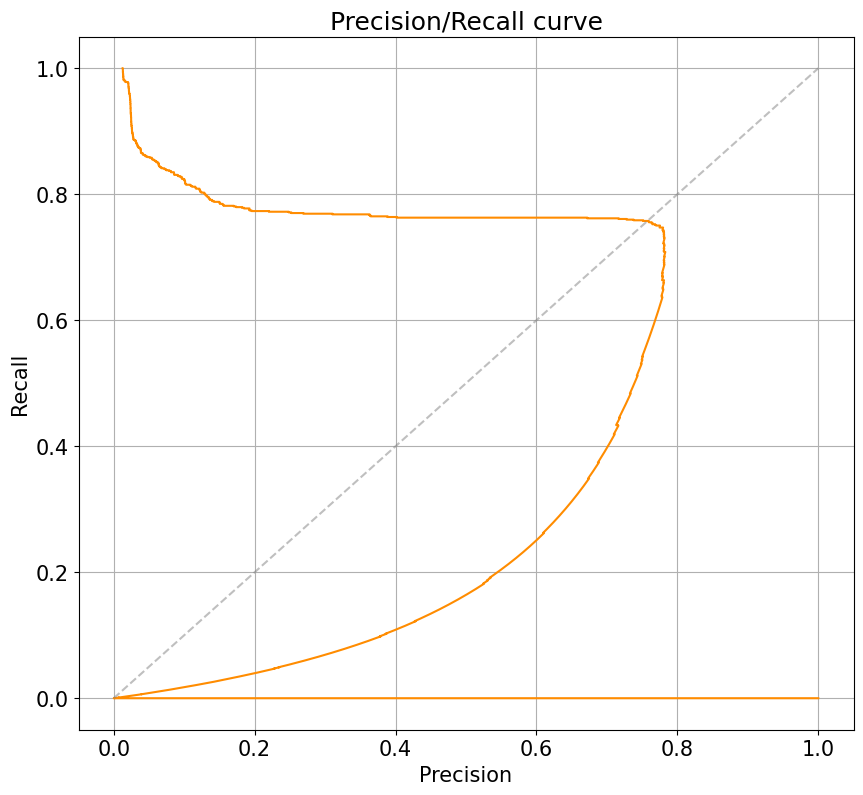

In [75]:
plot_pr_curve(predictions,save_as=os.path.join(logpath,'PR_curve.png'))

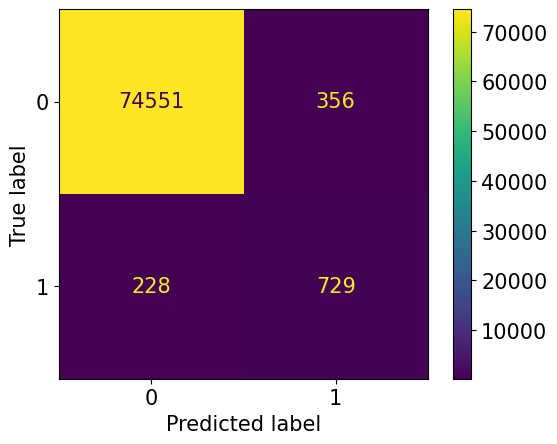


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74907
           1       0.67      0.76      0.71       957

    accuracy                           0.99     75864
   macro avg       0.83      0.88      0.86     75864
weighted avg       0.99      0.99      0.99     75864



In [76]:
plot_classification_report(predictions,th,save_fig_as=os.path.join(logpath,'CM.png'))

In [77]:
plot_distributions(predictions, th,save_as=os.path.join(logpath,'Prob_distr.png'))

# Window size 24

In [78]:
window_size = 24
labels = compute_labels(data,window_size)
for i,g in enumerate(data_list):
  g.y = labels[i]

  0%|          | 0/2963 [00:00<?, ?it/s]

In [79]:
train_data, test_data = train_test_split(data_list,TRAIN_SPLIT)
logpath = f'{BASE_LOGPATH}/{window_size:02d}'
logger_name = f'{logpath}/{LOGGER_NAME}'
model = train(train_data, logpath, logger_name,device,  NUM_EPOCHS, INITIAL_LR, TRAIN_BATCH_SIZE,ES_PATIENCE, ES_MIN_DELTA, MAX_NUM_CKPT,APPLY_WEIGHT_BALANCING)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/200	 Train Loss: 2094.8864150601867, Train Acc at 50%: 0.9892071680695086


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/200	 Train Loss: 565.2544574169608, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/200	 Train Loss: 474.80586478414335, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/200	 Train Loss: 432.611231785682, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/200	 Train Loss: 375.4783690831749, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/200	 Train Loss: 309.2776948140103, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/200	 Train Loss: 265.7422391166621, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/200	 Train Loss: 248.44049235224907, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/200	 Train Loss: 242.526178839714, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/200	 Train Loss: 239.50640329441578, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/200	 Train Loss: 235.7244094488189, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/200	 Train Loss: 231.097520137569, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/200	 Train Loss: 229.36833650104083, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/200	 Train Loss: 227.97615168793556, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/200	 Train Loss: 226.1681373879989, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/200	 Train Loss: 226.43413431079736, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/200	 Train Loss: 225.7407683953299, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/200	 Train Loss: 224.8893338763689, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/200	 Train Loss: 223.40128065888317, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/200	 Train Loss: 222.9265091863517, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/200	 Train Loss: 218.35722689836183, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/200	 Train Loss: 217.23221558512083, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/200	 Train Loss: 214.9907005158838, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/200	 Train Loss: 215.07548194406735, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/200	 Train Loss: 213.1541315956195, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/200	 Train Loss: 212.43716625938998, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/200	 Train Loss: 211.19666938184452, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/200	 Train Loss: 210.3871164811295, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/200	 Train Loss: 208.99257851389265, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/200	 Train Loss: 206.76753552357678, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/200	 Train Loss: 206.297764503575, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/200	 Train Loss: 202.36041723232873, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/200	 Train Loss: 205.6059598153679, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/200	 Train Loss: 204.52305638519323, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/200	 Train Loss: 203.62609738437868, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/200	 Train Loss: 198.68890849850666, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/200	 Train Loss: 201.61123178568195, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/200	 Train Loss: 197.09647931939543, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/200	 Train Loss: 200.021608290343, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/200	 Train Loss: 193.55887410625397, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/200	 Train Loss: 199.21680695085527, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/200	 Train Loss: 194.59046067517423, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/200	 Train Loss: 196.2901167526473, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/200	 Train Loss: 190.54321658068602, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/200	 Train Loss: 195.44277762693457, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/200	 Train Loss: 189.13469544755182, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/200	 Train Loss: 194.097520137569, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 48/200	 Train Loss: 188.3804416689293, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/200	 Train Loss: 190.66352158566386, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/200	 Train Loss: 183.65367906597882, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 51/200	 Train Loss: 191.4321884333424, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 52/200	 Train Loss: 184.33895601411893, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 53/200	 Train Loss: 191.41089691374785, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 54/200	 Train Loss: 183.4124468277672, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 55/200	 Train Loss: 187.50605258394424, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 56/200	 Train Loss: 180.2173273599421, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 57/200	 Train Loss: 185.69964476423206, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 58/200	 Train Loss: 177.88084894560595, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 59/200	 Train Loss: 185.62027106525477, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 60/200	 Train Loss: 178.08223594895466, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 61/200	 Train Loss: 176.5692257217848, Train Acc at 50%: 0.9895295954385013


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 62/200	 Train Loss: 181.7651823694452, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 63/200	 Train Loss: 172.5113132410173, Train Acc at 50%: 0.9895409086795185


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 64/200	 Train Loss: 181.4873744230247, Train Acc at 50%: 0.9894956557154494


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 65/200	 Train Loss: 177.61778215223097, Train Acc at 50%: 0.9895691917820617


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 66/200	 Train Loss: 170.0391890668839, Train Acc at 50%: 0.989501312335958


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 67/200	 Train Loss: 177.2110598244185, Train Acc at 50%: 0.9895126255769753


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 68/200	 Train Loss: 171.16631595619512, Train Acc at 50%: 0.9893655534437505


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 69/200	 Train Loss: 175.11990904154223, Train Acc at 50%: 0.989342926961716


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 70/200	 Train Loss: 166.95553896280205, Train Acc at 50%: 0.9896031315051136


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 71/200	 Train Loss: 172.68875011313241, Train Acc at 50%: 0.9899142456330889


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 72/200	 Train Loss: 169.67790071499684, Train Acc at 50%: 0.9892920173771382


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 73/200	 Train Loss: 163.4357407910218, Train Acc at 50%: 0.990151823694452


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 74/200	 Train Loss: 171.42967689383656, Train Acc at 50%: 0.990055661145805


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 75/200	 Train Loss: 170.8741515069237, Train Acc at 50%: 0.9892184813105258


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 76/200	 Train Loss: 163.9796474794099, Train Acc at 50%: 0.9900839442483482


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 77/200	 Train Loss: 167.9774753371346, Train Acc at 50%: 0.9899990949407186


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 78/200	 Train Loss: 166.64440220834464, Train Acc at 50%: 0.9892807041361209


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 79/200	 Train Loss: 157.33395556158928, Train Acc at 50%: 0.9898293963254593


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 80/200	 Train Loss: 165.4844103538782, Train Acc at 50%: 0.9946544936193321


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 81/200	 Train Loss: 163.34158068603494, Train Acc at 50%: 0.9958423839261472


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 82/200	 Train Loss: 161.4052855462033, Train Acc at 50%: 0.9953163182188434


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 83/200	 Train Loss: 155.34523486288353, Train Acc at 50%: 0.9958197574441126


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 84/200	 Train Loss: 159.63870033487194, Train Acc at 50%: 0.9955425830391891


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 85/200	 Train Loss: 154.1835007693004, Train Acc at 50%: 0.9959102633722509


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 86/200	 Train Loss: 155.43472259933026, Train Acc at 50%: 0.9957405647569916


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 87/200	 Train Loss: 152.09811973934293, Train Acc at 50%: 0.9958367273056385


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 88/200	 Train Loss: 156.02189112136844, Train Acc at 50%: 0.9953672278034211


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 89/200	 Train Loss: 150.09575527197032, Train Acc at 50%: 0.9958423839261472


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 90/200	 Train Loss: 154.9494184994117, Train Acc at 50%: 0.9958254140646212


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 91/200	 Train Loss: 155.01268214318037, Train Acc at 50%: 0.9960007693003892


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 92/200	 Train Loss: 153.644628473165, Train Acc at 50%: 0.9952427821522309


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 93/200	 Train Loss: 145.11074531631823, Train Acc at 50%: 0.9958027875825867


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 94/200	 Train Loss: 151.09387727396145, Train Acc at 50%: 0.9958197574441126


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 95/200	 Train Loss: 151.84386596072042, Train Acc at 50%: 0.9958423839261472


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 96/200	 Train Loss: 151.45226943614807, Train Acc at 50%: 0.995814100823604


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 97/200	 Train Loss: 148.545795999638, Train Acc at 50%: 0.9960233957824237


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 98/200	 Train Loss: 145.25976332699793, Train Acc at 50%: 0.995717938274957


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 99/200	 Train Loss: 143.12220562946874, Train Acc at 50%: 0.9956726853108878


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 100/200	 Train Loss: 141.14359896823242, Train Acc at 50%: 0.9954690469725767


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 101/200	 Train Loss: 139.50408408000723, Train Acc at 50%: 0.9959102633722509


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 102/200	 Train Loss: 141.5710132138655, Train Acc at 50%: 0.995972486197846


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 103/200	 Train Loss: 141.7063535161553, Train Acc at 50%: 0.9953728844239298


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 104/200	 Train Loss: 136.44454249253326, Train Acc at 50%: 0.9958536971671644


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 105/200	 Train Loss: 140.04383880894198, Train Acc at 50%: 0.9958423839261472


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 106/200	 Train Loss: 139.95042537786225, Train Acc at 50%: 0.9959328898542854


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 107/200	 Train Loss: 139.22454520771112, Train Acc at 50%: 0.9960290524029324


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 108/200	 Train Loss: 137.626957190696, Train Acc at 50%: 0.9954633903520681


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 109/200	 Train Loss: 134.18748303013848, Train Acc at 50%: 0.9958650104081818


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 110/200	 Train Loss: 136.24878948321114, Train Acc at 50%: 0.9958480405466558


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 111/200	 Train Loss: 136.71909222554078, Train Acc at 50%: 0.9960064259208978


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 112/200	 Train Loss: 135.2454860168341, Train Acc at 50%: 0.995576522762241


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 113/200	 Train Loss: 131.60572223730654, Train Acc at 50%: 0.9958536971671644


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 114/200	 Train Loss: 133.32922662684405, Train Acc at 50%: 0.9959385464747941


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 115/200	 Train Loss: 132.8772852746855, Train Acc at 50%: 0.9956274323468187


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 116/200	 Train Loss: 130.3039867861345, Train Acc at 50%: 0.995876323649199


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 117/200	 Train Loss: 130.24487510181916, Train Acc at 50%: 0.9956330889673274


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 118/200	 Train Loss: 128.51323649199023, Train Acc at 50%: 0.9958876368902163


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 119/200	 Train Loss: 129.540580595529, Train Acc at 50%: 0.9958989501312336


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 120/200	 Train Loss: 129.53131505113586, Train Acc at 50%: 0.995321974839352


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 121/200	 Train Loss: 126.76730925875646, Train Acc at 50%: 0.9958310706851299


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 122/200	 Train Loss: 128.95717938274956, Train Acc at 50%: 0.9958367273056385


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 123/200	 Train Loss: 129.23662774911756, Train Acc at 50%: 0.9959668295773373


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 124/200	 Train Loss: 128.03210697800705, Train Acc at 50%: 0.996017739161915


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 125/200	 Train Loss: 127.37895963435605, Train Acc at 50%: 0.9954068241469817


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 126/200	 Train Loss: 124.65306815096389, Train Acc at 50%: 0.9958876368902163


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 127/200	 Train Loss: 125.14755860258848, Train Acc at 50%: 0.9958650104081818


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 128/200	 Train Loss: 125.34963571363924, Train Acc at 50%: 0.9958536971671644


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 129/200	 Train Loss: 124.67225540772921, Train Acc at 50%: 0.9953106615983347


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 130/200	 Train Loss: 122.14954973300752, Train Acc at 50%: 0.9958593537876731


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 131/200	 Train Loss: 124.13859851570278, Train Acc at 50%: 0.9958819802697076


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 132/200	 Train Loss: 124.17808172685311, Train Acc at 50%: 0.9959611729568286


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 133/200	 Train Loss: 123.34692053579509, Train Acc at 50%: 0.9960120825414065


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 134/200	 Train Loss: 122.30860258846954, Train Acc at 50%: 0.9956839985519051


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 135/200	 Train Loss: 121.50945786949045, Train Acc at 50%: 0.9953955109059643


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 136/200	 Train Loss: 120.04207394334328, Train Acc at 50%: 0.9958876368902163


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 137/200	 Train Loss: 120.97771291519595, Train Acc at 50%: 0.9959555163363201


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 138/200	 Train Loss: 120.74642501583854, Train Acc at 50%: 0.9959102633722509


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 139/200	 Train Loss: 120.1199656077473, Train Acc at 50%: 0.9956048058647842


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 140/200	 Train Loss: 119.95007466739071, Train Acc at 50%: 0.9957858177210608


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 141/200	 Train Loss: 120.10910489637071, Train Acc at 50%: 0.9959555163363201


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 142/200	 Train Loss: 119.97305185989683, Train Acc at 50%: 0.99562177572631


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 143/200	 Train Loss: 119.01103040999186, Train Acc at 50%: 0.9954464204905421


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 144/200	 Train Loss: 117.76398316589737, Train Acc at 50%: 0.995893293510725


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 145/200	 Train Loss: 118.51449226174314, Train Acc at 50%: 0.9958819802697076


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 146/200	 Train Loss: 118.30715449361934, Train Acc at 50%: 0.9959159199927595


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 147/200	 Train Loss: 117.77823784957914, Train Acc at 50%: 0.9954633903520681


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 148/200	 Train Loss: 116.54457416960811, Train Acc at 50%: 0.9957462213775002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 149/200	 Train Loss: 116.85494162367635, Train Acc at 50%: 0.995717938274957


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 150/200	 Train Loss: 116.55665671101457, Train Acc at 50%: 0.9955142999366459


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 151/200	 Train Loss: 115.97391166621414, Train Acc at 50%: 0.99562177572631


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 152/200	 Train Loss: 115.72660421757625, Train Acc at 50%: 0.9956048058647842


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 153/200	 Train Loss: 115.6405783328808, Train Acc at 50%: 0.9955369264186804


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 154/200	 Train Loss: 115.19071861706942, Train Acc at 50%: 0.9957349081364829


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 155/200	 Train Loss: 115.27034120734908, Train Acc at 50%: 0.9955029866956285


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 156/200	 Train Loss: 114.74373246447642, Train Acc at 50%: 0.9957688478595348


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 157/200	 Train Loss: 114.82590053398498, Train Acc at 50%: 0.9954860168341026


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 158/200	 Train Loss: 114.24557652276224, Train Acc at 50%: 0.9957801611005521


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 159/200	 Train Loss: 114.40113358674994, Train Acc at 50%: 0.9954916734546113


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 160/200	 Train Loss: 113.84379808127433, Train Acc at 50%: 0.9957688478595348


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 161/200	 Train Loss: 113.93361390171056, Train Acc at 50%: 0.9954973300751199


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 162/200	 Train Loss: 113.47754321658068, Train Acc at 50%: 0.9956839985519051


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 163/200	 Train Loss: 113.45286903792199, Train Acc at 50%: 0.9955142999366459


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 164/200	 Train Loss: 113.07741650828129, Train Acc at 50%: 0.995717938274957


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 165/200	 Train Loss: 113.09543850122184, Train Acc at 50%: 0.9955312697981717


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 166/200	 Train Loss: 112.78713005701873, Train Acc at 50%: 0.9956839985519051


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 167/200	 Train Loss: 112.70585573355055, Train Acc at 50%: 0.9955369264186804


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 168/200	 Train Loss: 112.3750678794461, Train Acc at 50%: 0.9956839985519051


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 169/200	 Train Loss: 112.36399221649017, Train Acc at 50%: 0.9955482396596977


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 170/200	 Train Loss: 112.14405149787311, Train Acc at 50%: 0.9956500588288533


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 171/200	 Train Loss: 112.03963028328356, Train Acc at 50%: 0.9955199565571545


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 172/200	 Train Loss: 111.72944384107159, Train Acc at 50%: 0.995638745587836


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 173/200	 Train Loss: 111.73250972938727, Train Acc at 50%: 0.9956048058647842


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 174/200	 Train Loss: 111.57471264367815, Train Acc at 50%: 0.9956104624852928


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 175/200	 Train Loss: 111.35745316318219, Train Acc at 50%: 0.9956161191058014


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 176/200	 Train Loss: 111.28977735541677, Train Acc at 50%: 0.9955708661417323


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 177/200	 Train Loss: 111.11239704950674, Train Acc at 50%: 0.9956500588288533


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 178/200	 Train Loss: 111.07621730473346, Train Acc at 50%: 0.9955312697981717


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 179/200	 Train Loss: 110.83320888768215, Train Acc at 50%: 0.9956274323468187


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 180/200	 Train Loss: 110.80558195311792, Train Acc at 50%: 0.995576522762241


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 181/200	 Train Loss: 110.6730360213594, Train Acc at 50%: 0.9956104624852928


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 182/200	 Train Loss: 110.54183636528192, Train Acc at 50%: 0.995559552900715


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 183/200	 Train Loss: 110.42052448185356, Train Acc at 50%: 0.9955878360032582


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 184/200	 Train Loss: 110.33009774640239, Train Acc at 50%: 0.9956104624852928


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 185/200	 Train Loss: 110.23786089238845, Train Acc at 50%: 0.9955821793827496


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 186/200	 Train Loss: 110.09009865146167, Train Acc at 50%: 0.9956048058647842


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 187/200	 Train Loss: 110.07229161010046, Train Acc at 50%: 0.9955821793827496


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 188/200	 Train Loss: 109.91773011132229, Train Acc at 50%: 0.9956104624852928


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 189/200	 Train Loss: 109.8686532717893, Train Acc at 50%: 0.9955934926237668


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 190/200	 Train Loss: 109.72802968594443, Train Acc at 50%: 0.9955991492442755


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 191/200	 Train Loss: 109.70303873653724, Train Acc at 50%: 0.9956048058647842


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 192/200	 Train Loss: 109.58253009322111, Train Acc at 50%: 0.9956104624852928


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 193/200	 Train Loss: 109.52887139107611, Train Acc at 50%: 0.9956104624852928


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 194/200	 Train Loss: 109.42528735632185, Train Acc at 50%: 0.9956161191058014


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 195/200	 Train Loss: 109.40089600868856, Train Acc at 50%: 0.9955878360032582


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 196/200	 Train Loss: 109.25933342383927, Train Acc at 50%: 0.9956161191058014


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 197/200	 Train Loss: 109.24392478957371, Train Acc at 50%: 0.995576522762241


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 198/200	 Train Loss: 109.13263643768667, Train Acc at 50%: 0.9956330889673274


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 199/200	 Train Loss: 109.11801973029233, Train Acc at 50%: 0.995559552900715


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 200/200	 Train Loss: 109.01242193863698, Train Acc at 50%: 0.9956330889673274


In [80]:
test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)
predictions = get_predictions(model,test_loader,device)
predictions.to_csv(os.path.join(logpath,'predictions.csv'))

  0%|          | 0/14 [00:00<?, ?it/s]

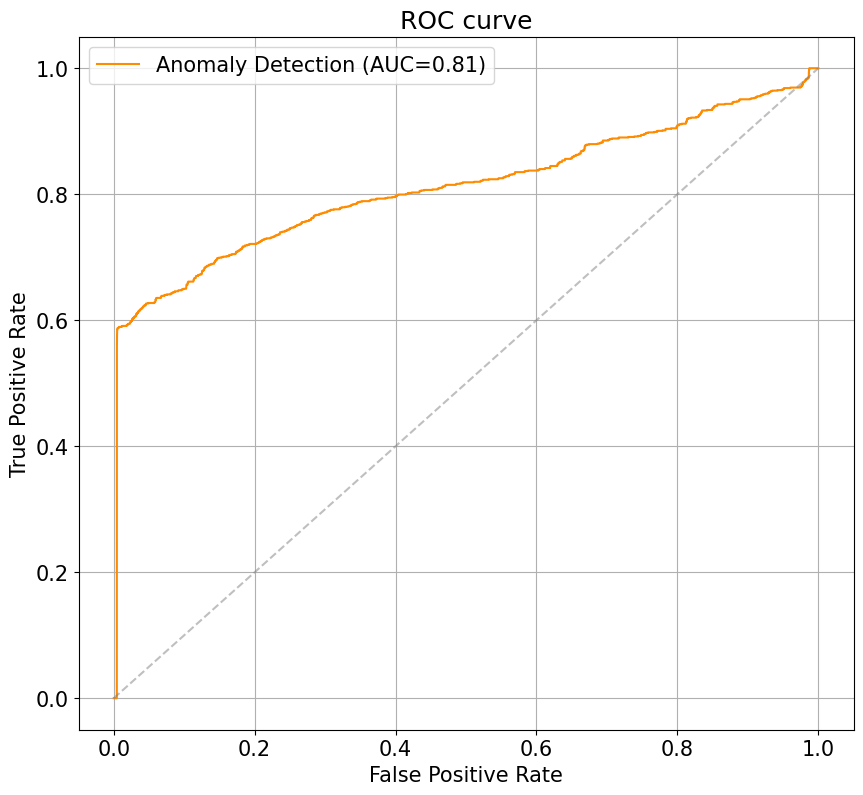


Best probability threshold: p=5.98%


In [81]:
fpr,tpr,thr = plot_roc_curve(predictions,save_as=os.path.join(logpath,'ROC_curve.png'))
th = thr[np.argmax(tpr-fpr)]
print(f"\nBest probability threshold: p={th*100:.2f}%")


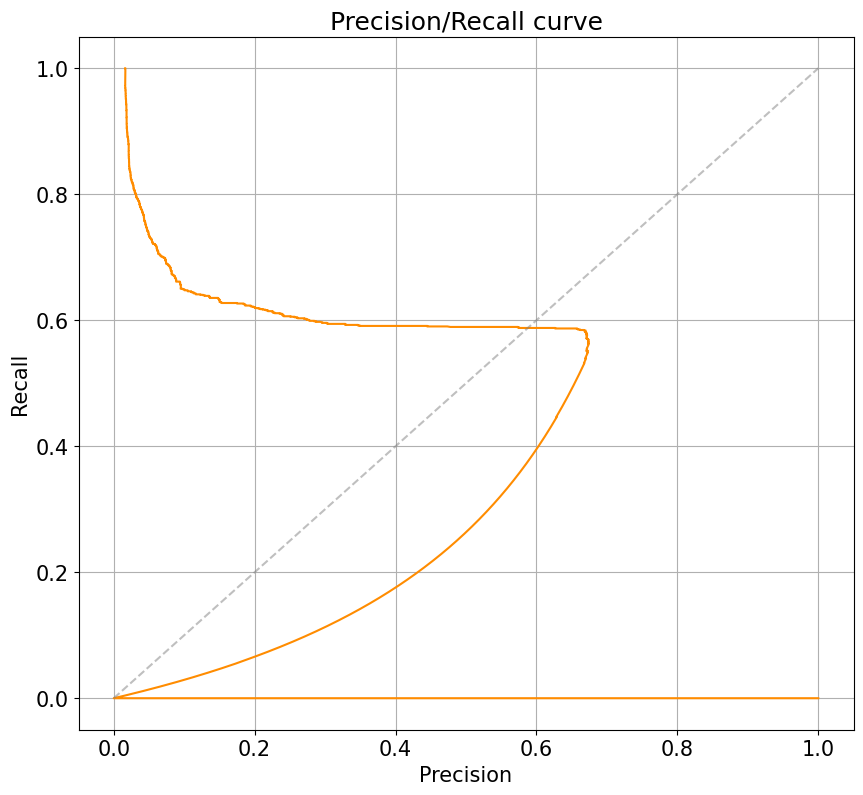

In [82]:
plot_pr_curve(predictions,save_as=os.path.join(logpath,'PR_curve.png'))

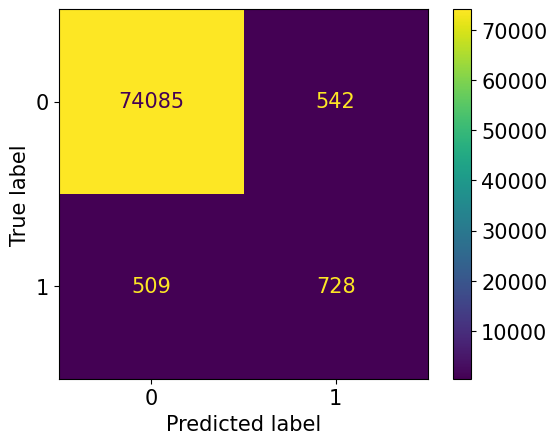


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     74627
           1       0.57      0.59      0.58      1237

    accuracy                           0.99     75864
   macro avg       0.78      0.79      0.79     75864
weighted avg       0.99      0.99      0.99     75864



In [83]:
plot_classification_report(predictions,th,save_fig_as=os.path.join(logpath,'CM.png'))

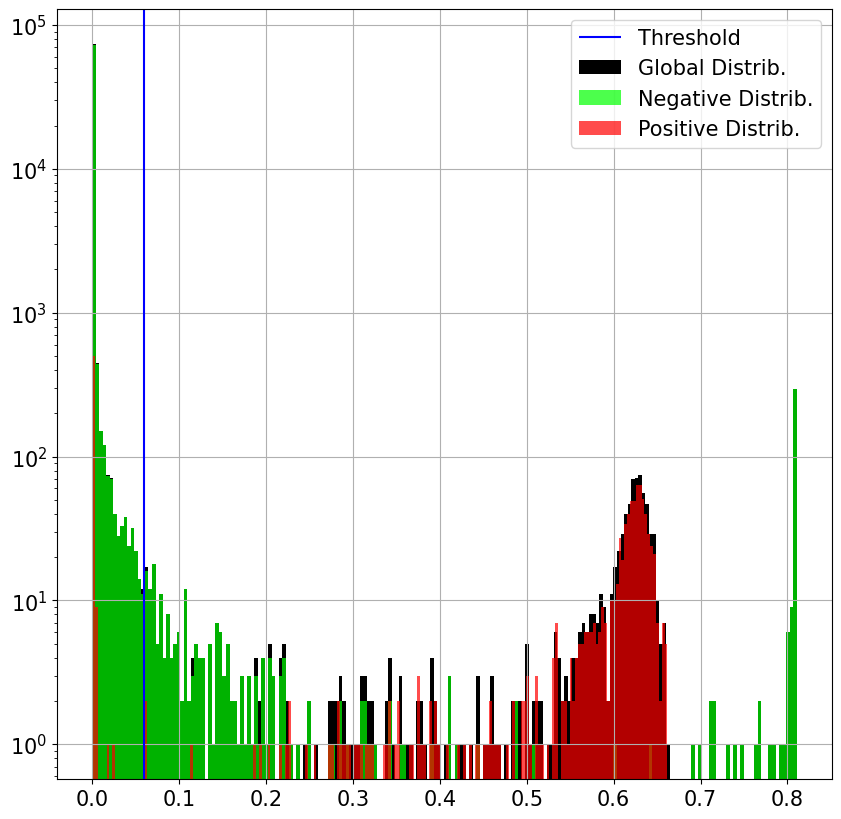

In [84]:
plot_distributions(predictions, th,save_as=os.path.join(logpath,'Prob_distr.png'))

# Window size 64

In [85]:
window_size = 64
labels = compute_labels(data,window_size)
for i,g in enumerate(data_list):
  g.y = labels[i]

  0%|          | 0/2963 [00:00<?, ?it/s]

In [ ]:
train_data, test_data = train_test_split(data_list,TRAIN_SPLIT)
logpath = f'{BASE_LOGPATH}/{window_size:02d}'
logger_name = f'{logpath}/{LOGGER_NAME}'
model = train(train_data, logpath, logger_name,device,  NUM_EPOCHS, INITIAL_LR, TRAIN_BATCH_SIZE,ES_PATIENCE, ES_MIN_DELTA, MAX_NUM_CKPT,APPLY_WEIGHT_BALANCING)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)
predictions = get_predictions(model,test_loader,device)
predictions.to_csv(os.path.join(logpath,'predictions.csv'))

In [ ]:
fpr,tpr,thr = plot_roc_curve(predictions,save_as=os.path.join(logpath,'ROC_curve.png'))
th = thr[np.argmax(tpr-fpr)]
print(f"\nBest probability threshold: p={th*100:.2f}%")

In [ ]:
plot_pr_curve(predictions,save_as=os.path.join(logpath,'PR_curve.png'))

In [ ]:
plot_classification_report(predictions,th,save_fig_as=os.path.join(logpath,'CM.png'))

In [ ]:
plot_distributions(predictions, th,save_as=os.path.join(logpath,'Prob_distr.png'))

# Window size 192

In [ ]:
window_size = 192
labels = compute_labels(data,window_size)
for i,g in enumerate(data_list):
  g.y = labels[i]

In [ ]:
train_data, test_data = train_test_split(data_list,TRAIN_SPLIT)
logpath = f'{BASE_LOGPATH}/{window_size:02d}'
logger_name = f'{logpath}/{LOGGER_NAME}'
model = train(train_data, logpath, logger_name,device,  NUM_EPOCHS, INITIAL_LR, TRAIN_BATCH_SIZE,ES_PATIENCE, ES_MIN_DELTA, MAX_NUM_CKPT,APPLY_WEIGHT_BALANCING)

In [ ]:
test_loader = DataLoader(test_data, batch_size = TEST_BATCH_SIZE, shuffle = False)
predictions = get_predictions(model,test_loader,device)
predictions.to_csv(os.path.join(logpath,'predictions.csv'))

In [ ]:
fpr,tpr,thr = plot_roc_curve(predictions,save_as=os.path.join(logpath,'ROC_curve.png'))
th = thr[np.argmax(tpr-fpr)]
print(f"\nBest probability threshold: p={th*100:.2f}%")

In [ ]:
plot_pr_curve(predictions,save_as=os.path.join(logpath,'PR_curve.png'))

In [ ]:
plot_classification_report(predictions,th,save_fig_as=os.path.join(logpath,'CM.png'))

In [ ]:
plot_distributions(predictions, th,save_as=os.path.join(logpath,'Prob_distr.png'))

In [ ]:
! rm -r drive/MyDrive/HPCDATA/simple
! cp -r out drive/MyDrive/HPCDATA/simple